In [1]:
import sys
sys.path.append('..')

# from alphazero.molecule import build_molecules
import rdkit

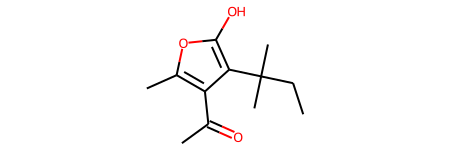

In [14]:
mol_rad = rdkit.Chem.MolFromSmiles('CCC(C)(C)c1c([O])oc(C)c1C(C)=O')
mol = rdkit.Chem.MolFromSmiles('CCC(C)(C)c1c(O)oc(C)c1C(C)=O')
mol

In [5]:
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import Draw

enumerator = rdMolStandardize.TautomerEnumerator()

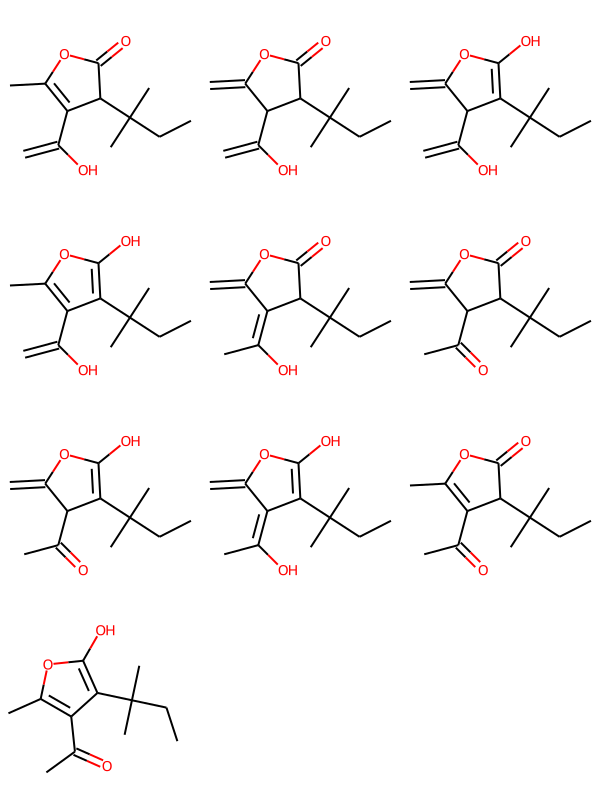

In [12]:
tauts = enumerator.Enumerate(mol)
Draw.MolsToGridImage(tauts)

In [13]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

In [17]:
from reward import predict, stability_model
from alphazero.node import Node
import numpy as np

def pred_spins(mol):
    spins, _ = predict(stability_model, 
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in Node(mol).policy_inputs.items()})
    
    return spins.numpy().flatten()

In [18]:
pred_spins(mol_rad)

array([0.00417612, 0.02052567, 0.02537291, 0.01524112, 0.01524112,
       0.34369826, 0.01230018, 0.19819288, 0.00629792, 0.25581446,
       0.02429372, 0.06491436, 0.00407876, 0.00361601, 0.0062365 ],
      dtype=float32)

In [67]:
# Code for raster image drawing
import rdkit

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdDepictor
from IPython.display import SVG

d = rdMolDraw2D.MolDraw2DSVG(200, 200)
SimilarityMaps.GetSimilarityMapFromWeights(mol_rad, [float(i) for i in pred_spins(mol_rad)], draw2d=d, includeAtomNumbers=True)
d.FinishDrawing()
SVG(d.GetDrawingText())

ArgumentError: Python argument types in
    MolDraw2DSVG.__init__(MolDraw2DSVG, int, int)
did not match C++ signature:
    __init__(_object*, int, int, int, int, bool)
    __init__(_object*, int, int, int, int)
    __init__(_object*, int, int)

In [22]:
spins = pred_spins(mol_rad)

In [42]:
np.where(spins > 0.1)

(array([5, 7, 9]),)

In [57]:
mol.GetAtomWithIdx(5).GetTotalNumHs()

0

In [54]:
tauts[0].GetAtomWithIdx(5)

AttributeError: 'Atom' object has no attribute 'GetNumTotalHs'

In [49]:
for taut in tauts:
    atom = mol.GetAtomWithIdx(5)
    print(atom.GetTotalNumHs())

3
3
3
3
3
3
3
3
3
3


In [70]:
def get_tautomers():    
    for atom_idx in np.where(spins > 0.1)[0]:
        for taut in tauts:
            atom = taut.GetAtomWithIdx(int(atom_idx))
            if atom.GetTotalNumHs() > 0:
                yield (atom_idx, taut)
                

In [71]:
list(get_tautomers())

[(5, <rdkit.Chem.rdchem.Mol at 0x7f99cd1441b0>),
 (5, <rdkit.Chem.rdchem.Mol at 0x7f99cd1445d0>),
 (5, <rdkit.Chem.rdchem.Mol at 0x7f99cd1446f0>),
 (5, <rdkit.Chem.rdchem.Mol at 0x7f99cd144750>),
 (5, <rdkit.Chem.rdchem.Mol at 0x7f99cd1447b0>),
 (7, <rdkit.Chem.rdchem.Mol at 0x7f99cd144870>),
 (7, <rdkit.Chem.rdchem.Mol at 0x7f99cd144810>),
 (7, <rdkit.Chem.rdchem.Mol at 0x7f99cd1448d0>),
 (7, <rdkit.Chem.rdchem.Mol at 0x7f99cd144930>),
 (7, <rdkit.Chem.rdchem.Mol at 0x7f99cd144690>)]

In [2]:
from alphazero.molecule_filters import check_all_filters, h2, h3, h4, s1, s2, s3, s4, f2

In [4]:
starting_mol = rdkit.Chem.MolFromSmiles('C/C=C/C')
children = list(build_molecules(starting_mol, atom_additions=('C', 'N', 'O', 'S'), sa_score_threshold=3.5, tryEmbedding=False, stereoisomers=True))
len(children)
[rdkit.Chem.MolToSmiles(child) for child in children]

['C/C=C/CC',
 'C/C=C/CN',
 'C/C=C/CO',
 'C/C=C/C=O',
 'CC=C(C)C',
 'C/C=C(/C)N',
 'C/C=C(/C)O']

In [ ]:
children

In [ ]:
starting_mol

In [ ]:
starting_mol

In [ ]:
rdkit.Chem.FindPotentialStereoBonds(starting_mol)       
for bond in starting_mol.GetBonds():
    print(bond.GetStereo())

In [ ]:
starting_mol

In [ ]:
from alphazero.molecule import sascorer

In [ ]:
import rdkit
from collections import Counter

def h2(mol):
    """no atom shared by two small rings"""
    return mol.HasSubstructMatch(rdkit.Chem.MolFromSmarts('[R2r3,r4]([R1r3,r4])[R1r3,r4]'))

def h3(mol):
    """no bridgehead in 3 rings"""
    return mol.HasSubstructMatch(rdkit.Chem.MolFromSmarts('[R3]'))

def h4(mol):
    """one small ring"""
    ring_counts = Counter((len(ring) for ring in child.GetRingInfo().AtomRings()))
    return (ring_counts[3] + ring_counts[4]) <= 1

def s1(mol):
    """no allenes"""
    return mol.HasSubstructMatch(rdkit.Chem.MolFromSmarts('C=C=C'))
    
def s2(mol):
    """no unsaturations in 3-membered rings"""
    for bonds in filter(lambda x: len(x) == 3, mol.GetRingInfo().BondRings()):
        for bond in bonds:
            if mol.GetBondWithIdx(bond).GetBondTypeAsDouble() > 1:
                return True
    else:
        return False

def s3(mol):
    """at most one sp2-center in 4-membered rings"""
    for atoms in filter(lambda x: len(x) == 4, mol.GetRingInfo().AtomRings()):
        c_atoms = filter(lambda x: mol.GetAtomWithIdx(x).GetSymbol() == 'C', atoms)
        atom_centers = Counter((mol.GetAtomWithIdx(atom).GetHybridization() for atom in c_atoms))
        if atom_centers[rdkit.Chem.rdchem.HybridizationType.SP2] > 1:
            return True
    else:
        return False
    

def s4(mol):
    """No triple bonds in ring"""
    return mol.HasSubstructMatch(rdkit.Chem.MolFromSmarts('[R]#[R]'))


def f2(mol):
    """at most one sp2-center in 4-membered rings"""
    for atoms in filter(lambda x: len(x) <= 4, mol.GetRingInfo().AtomRings()):
        atom_types = Counter((mol.GetAtomWithIdx(atom).GetSymbol() for atom in atoms))
        if atom_types['O'] + atom_types['S'] + atom_types['N'] > 1:
            return True
    else:
        return False

In [ ]:
starting_mol

In [ ]:
for atoms in filter(lambda x: len(x) == 4, mol.GetRingInfo().AtomRings()):
    pass

In [ ]:
[mol.GetAtomWithIdx(atom).GetHybridization() for atom in atoms]

In [ ]:
rdkit.Chem.MolFromSmiles('C1NC1')

In [ ]:
[(atom.GetSymbol(), atom.GetHybridization())
 for atom in rdkit.Chem.MolFromSmiles('C1NC1').GetAtoms()]

In [ ]:
sum([h2(child) for child in children]) / len(children)

In [ ]:
children

In [ ]:
children[0].HasSubstructMatch(rdkit.Chem.MolFromSmarts('[R2r3,r4]([R1r3,r4])[R1r3,r4]'))

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
gpus

In [ ]:
import numpy as np
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='paper',
    font_scale=8/8.8,
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [ ]:
import psycopg2
import pandas as pd

dbparams = {
    'dbname': 'bde',
    'port': 5432,
    'host': 'yuma.hpc.nrel.gov',
    'user': 'bdeops',
    'password': 'BD30ps99!',
    'options': f'-c search_path=bde',
}

with psycopg2.connect(**dbparams) as conn:
    cdf = pd.read_sql_query("""
    SELECT * from unique_compound where status='finished' and type='molecule';
    """, conn)

In [ ]:
import numpy as np
import ase
import ase.optimize
from ase.units import Hartree
import xtb
import torch
device = torch.device('cpu')
from xtb.ase.calculator import XTB

from rdkit.Chem import AllChem
from rdkit.Geometry import Point3D

Hartree, kcal, kJ, mol_unit = 27.211386024367243, 2.611447418269555e+22, 6.241509125883258e+21, 6.022140857e+23
hartree_to_kcal = 627.509

atomic_formation_energies = pd.Series({
    'H': 216.0 / 4.184,
    'C': 711.2 / 4.184,
    'N': 470.8 / 4.184,
    'O': 246.8 / 4.184,
    'S': 274.9 / 4.184,
})

def optimize(input_mol):
    
    mol = AllChem.AddHs(input_mol)
    AllChem.EmbedMolecule(mol, randomSeed=42)
#     prop = AllChem.MMFFGetMoleculeProperties(mol, mmffVariant="MMFF94s")
#     ff = AllChem.MMFFGetMoleculeForceField(mol, prop, confId=0)
#     ff.Minimize()
    
    #verbose
    verbose = True

    #setup non rdkit energy calculations
    opt = True # switch to off for single point only
    opt_precision = 0.05 # toggle for optimization convergence
    convergence = 1

    #adjust opt convergence criteria (convergence defaults to 1.0)
    opt_precision = opt_precision * convergence

    cartesians = mol.GetConformers()[0].GetPositions()
    elements = ''
    for atom in mol.GetAtoms(): elements += atom.GetSymbol()
    coordinates = torch.tensor([cartesians.tolist()], requires_grad=True, device=device)
    sqm_energy, converged = 0.0, -1
    
    ase_molecule = ase.Atoms(elements, positions=coordinates.tolist()[0], calculator=XTB(method='GFN2-xTB')) #define ase molecule using GFN2 Calculator
    if opt == True:
        # if verbose: print("o  Initial XTB energy", ase_molecule.get_potential_energy()/Hartree,'Eh',ase_molecule.get_potential_energy(),'eV') #Hartree, eV
        optimizer = ase.optimize.BFGS(ase_molecule, logfile='xtb.opt')
        optimizer.run(fmax=float(opt_precision))
        species_coords = ase_molecule.get_positions().tolist()
        coordinates = torch.tensor([species_coords], requires_grad=True, device=device)
        converged = 0
               
    ###############################################################################
    # Now let's compute energy:
    xtb_energy = ase_molecule.get_potential_energy()
    sqm_energy = xtb_energy / Hartree * hartree_to_kcal
    #if verbose: print("o  Final XTB E:",xtb_energy/Hartree,'Eh',xtb_energy,'eV') #Hartree, eV
    ###############################################################################

    energy, converged, cartesians = sqm_energy, converged, np.array(coordinates.tolist()[0])
    # update coordinates of mol object
    for j in range(mol.GetNumAtoms()):
        [x,y,z] = cartesians[j]
        mol.GetConformer().SetAtomPosition(j,Point3D(x,y,z))
        
    assert converged == 0

    return energy

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
smiles_to_test = cdf.sample(100, random_state=1).smiles
energies = smiles_to_test.progress_apply(lambda x: optimize(rdkit.Chem.MolFromSmiles(x)))

In [ ]:
from collections import Counter
def get_elems(smiles):
    mol = rdkit.Chem.AddHs(rdkit.Chem.MolFromSmiles(smiles))
    return pd.Series(Counter((atom.GetSymbol() for atom in mol.GetAtoms())))     

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
elems = smiles_to_test.apply(get_elems).fillna(0)

In [ ]:
reg = LinearRegression().fit(elems, energies)

In [ ]:
plt.plot(reg.predict(elems), energies, '.')

In [ ]:
from ase.collections import g2

In [ ]:
# (pd.Series(Counter((atom.GetSymbol() for atom in mol.GetAtoms()))) * atomic_formation_energies).sum()`

In [ ]:
starting_energy

In [ ]:
1329.6367112810708 + starting_energy

In [ ]:
starting_mol = rdkit.Chem.MolFromSmiles('CCCCCC')
children = list(build_molecules(starting_mol, atom_additions=('C', 'N', 'O', 'S'), sa_score_threshold=3.5))

In [ ]:
starting_energy = optimize(starting_mol)

In [ ]:
h2_energy = optimize(rdkit.Chem.MolFromSmiles('[HH]'))

In [ ]:
starting_energy

In [ ]:
rings = [mol for mol in children if mol.GetNumAtoms() == 6]

In [ ]:
h2_energy

In [ ]:
child_energies = pd.Series({rdkit.Chem.MolToSmiles(child): optimize(child) for child in rings})

In [ ]:
((child_energies + 2*h2_energy) - starting_energy).sort_values().round(2)

In [ ]:
# Load the game buffer
with psycopg2.connect(**config.dbparams) as conn:
    df = pd.read_sql_query("select * from {}_replay where experiment_id = %s".format(
        'StablePSJ_fixed_redox'), conn, params=('002',))

In [ ]:
import io
import rdkit.Chem

def get_visit_probs(data):
    with io.BytesIO(data) as f:
        parsed_data = dict(np.load(f, allow_pickle=True).items())
        return parsed_data['visit_probs']
    
def get_children_smiles(smiles):
    return [rdkit.Chem.MolToSmiles(mol) for mol in build_molecules(rdkit.Chem.MolFromSmiles(smiles), atom_additions=('C', 'N', 'O', 'S'), sa_score_threshold=3.5)]

In [ ]:
starting_mol = rdkit.Chem.MolFromSmiles('CCC(C)(CC)C(=C(C)O)C(C)C')

In [ ]:
starting_mol = rdkit.Chem.MolFromSmiles('Sc1ccccc1')
starting_energy = get_minimum_ff_energy(starting_mol)
children = list(build_molecules(starting_mol, atom_additions=('C', 'N', 'O', 'S'), sa_score_threshold=3.5))

pd.Series({rdkit.Chem.MolToSmiles(child): get_minimum_ff_energy(child) - starting_energy for child in children}).sort_values()

In [ ]:
starting_mol = rdkit.Chem.MolFromSmiles('CCCCCC')
starting_energy = get_minimum_ff_energy(starting_mol)
children = list(build_molecules(starting_mol, atom_additions=('C', 'N', 'O', 'S'), sa_score_threshold=3.5))

pd.Series({rdkit.Chem.MolToSmiles(child): get_minimum_ff_energy(child) - starting_energy for child in children}).sort_values()

In [ ]:
starting_mol = rdkit.Chem.MolFromSmiles(r'c1ccccc1')
starting_energy = get_minimum_ff_energy(starting_mol)
children = list(build_molecules(starting_mol, atom_additions=('C', 'N', 'O', 'S'), sa_score_threshold=3.5))

pd.Series({rdkit.Chem.MolToSmiles(child): get_minimum_ff_energy(child) - starting_energy for child in children}).sort_values()

In [ ]:
build_molecules(rdkit.Chem.MolFromSmiles(smiles), atom_additions=('C', 'N', 'O', 'S'), sa_score_threshold=3.5)

In [ ]:
mol = rdkit.Chem.MolFromSmiles(r'CCC(C)(CC)C(=C(C)O)C(C)C')

In [ ]:
opts = StereoEnumerationOptions(unique=True)
[rdkit.Chem.MolToSmiles(m) for m in EnumerateStereoisomers(mol, options=opts)]

In [ ]:
rdkit.Chem.MolToSmiles(mol)

In [ ]:
print('C/C=C(\\C)O')